In [2]:
from snake_game import SnakeGame
import tkinter as tk
import torch
from torch import nn
from torch import optim
from model_brain import *
import random
import math

epoch = 100

root = tk.Tk()
Q_model = Brain()
target_model = Brain()
target_model.load_state_dict(Q_model.state_dict())
target_model.eval()
memory = ReplayMemory(5000)
gamma =  0.9
optimizer = torch.optim.Adam(Q_model.parameters(), lr=0.01)
loss_f = nn.SmoothL1Loss()
epsilon = 0.1


loss_set = []
score_set = []

activate = {0 : "Up", 1 : "Down", 2 : "Left", 3 : "Right"}

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005

steps_done = 0

def train_model(game, memory, optimizer,loss_f, gamma, batch_size=64):
    if len(memory) < batch_size:
        return False

    # 경험 배치 샘플링
    batch = memory.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.stack(states)
    actions = torch.tensor(actions)
    next_states = torch.stack(next_states)
    #print(next_states)

    #inputs = torch.zeros((min(len(memory), batch_size)), states.shape[1], states.shape[2])
    #targets = torch.zeros((min(len(memory), batch_size)), states.shape[1], states.shape[2])

    # Q값 계산
    Q_values = Q_model(states)
    Q_value = Q_values.gather(1, actions.unsqueeze(1))

    with torch.no_grad():
        next_Q_values = target_model(next_states)
        next_Q_value = next_Q_values.max(1)[0].detach()


    Q = torch.tensor(rewards).float() + gamma * next_Q_value
    loss = loss_f(Q_value, Q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            #print(Q_model(state))
            return torch.argmax(Q_model(state)).item()
    else:
        return random.choice([0,1,2,3])


for e in range(1, epoch + 1):
    game = SnakeGame(root)
    r_loss = 0
    reward = 0
    while not game.game_over:
        # Q-model을 통해 상태에서 Q값을 예측
        #game.update()
        state_tensor = game.board_tensor()
        
        action = select_action(state_tensor.unsqueeze(0))
        r_action = activate[action]

        game.change_direction(r_action)  
        game.move_snake()
        game.update()
        # 다음 상태 계산
        next_state_tensor = game.board_tensor()
        
        reward = game.reward
        
        print(r_action)
        
        done = game.game_over  # 게임 오버 체크

        memory.push(state_tensor, action, reward, next_state_tensor, done)
        
        target_model.load_state_dict(Q_model.state_dict())
        loss = train_model(game, memory, optimizer, loss_f, gamma)
        if loss is not False:
            r_loss += loss
 

    loss_set.append(r_loss / 64)
    score_set.append(game.score)  # 게임 점수 추가
    print(f"Epoch {e}, Loss: {r_loss / 64}, Score: {game.score}")


Up
Right
Right
Down
Right
Down
Right
Left
Down
Down
Right
Left
Left
Epoch 1, Loss: 0.0, Score: 0
Left
Up
Left
Right
Left
Down
Down
Left
Epoch 2, Loss: 0.0, Score: 0
Up
Left
Up
Left
Right
Epoch 3, Loss: 0.0, Score: 0
Up
Right
Up
Left
Up
Epoch 4, Loss: 0.0, Score: 0
Left
Right
Left
Right
Down
Right
Right
Down
Up
Up
Up
Right
Left
Epoch 5, Loss: 0.0, Score: 0
Right
Left
Left
Right
Down
Right
Right
Left
Up
Up
Up
Down
Epoch 6, Loss: 0.0, Score: 0
Up
Left
Right
Up
Right
Left
Left
Down
Up
Right
Up
Left
Right
Left
Up
Right
Up
Epoch 7, Loss: 2.8084950745105743, Score: 0
Left
Up


C:\Users\singo\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
C:\Users\singo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:939: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Up
Down
Epoch 8, Loss: 1.1816738545894623, Score: 0
Right
Down
Up
Right
Down
Down
Right
Down
Up
Right
Left
Up
Right
Right
Left
Epoch 9, Loss: 4.474847674369812, Score: 0
Right
Right
Up
Down
Right
Down
Right
Down
Left
Up
Up
Up
Epoch 10, Loss: 3.69983446598053, Score: 0
Right
Up
Right
Right
Up
Right
Down
Up
Right
Down
Left
Down
Down
Up
Right
Right
Down
Up
Right
Right
Epoch 11, Loss: 6.002912104129791, Score: 0
Left
Up
Up
Up
Epoch 12, Loss: 1.3441526591777802, Score: 0
Up
Down
Up
Epoch 13, Loss: 0.9888701438903809, Score: 0
Right
Down
Down
Right
Right
Right
Left
Right
Up
Right
Down
Right
Epoch 14, Loss: 3.6081842184066772, Score: 0
Up
Up
Right
Up
Epoch 15, Loss: 1.2847075760364532, Score: 0
Up
Down
Up
Epoch 16, Loss: 0.984123021364212, Score: 0
Right
Up
Down
Down
Epoch 17, Loss: 1.3084578216075897, Score: 0
Left
Left
Right
Left
Up
Up
Right
Right
Right
Down
Right
Epoch 18, Loss: 3.5289410054683685, Score: 0
Down
Down
Up
Right
Up
Up
Up
Left
Up
Left
Up
Right
Right
Down
Right
Up
Right
Up
Epoc

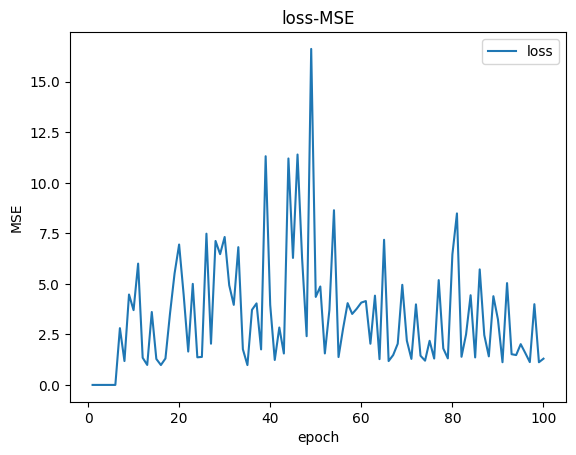

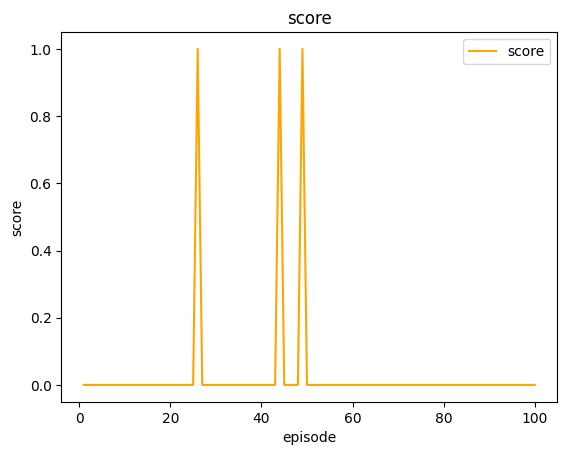

In [3]:
import matplotlib.pyplot as plt

epoch_x = [e for e in range(1, epoch + 1)]
loss_y = loss_set
score_y = score_set


plt.figure(1)
plt.plot(epoch_x, loss_y, label='loss')
plt.title('loss-MSE')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()

plt.figure(2)
plt.plot(epoch_x, score_y, label='score', color='orange')
plt.title('score')
plt.xlabel('episode')
plt.ylabel('score')
plt.legend()

plt.show()


In [4]:
from snake_game import SnakeGame
import tkinter as tk
root = tk.Tk()
game = SnakeGame(root)
root.mainloop()


In [3]:
print(reward)

import torch

x = torch.randn(64,4)
print(x)
print(torch.max(x, dim = 1))


a = torch.randn(1, 3, 25 ,25)
b = torch.randn(1, 3, 25 ,25)
Q_model(a)


-90
tensor([[-2.9675e+00,  5.2908e-01, -9.3825e-01,  1.4031e+00],
        [ 2.0706e-01,  1.3198e+00,  1.6969e+00, -1.9579e+00],
        [ 4.6648e-01,  4.7296e-01,  5.5596e-01, -1.1856e+00],
        [ 1.1969e-01, -5.9109e-01,  1.6809e-03, -2.4752e+00],
        [-1.3148e-01,  7.8563e-01, -2.1226e+00, -1.8931e+00],
        [-2.4843e-01, -1.7274e-01,  4.6505e-01, -7.3865e-01],
        [ 6.4285e-01,  8.2630e-01,  6.6088e-01,  4.0915e-01],
        [ 1.1884e+00, -3.9851e-01,  1.5075e+00, -2.7930e-01],
        [-5.4333e-01, -6.3146e-01, -1.2641e+00, -1.2426e+00],
        [-1.5829e-01, -9.9579e-01, -1.3401e+00, -1.9209e+00],
        [-1.9820e+00,  2.1709e-01, -8.8485e-01,  9.9617e-01],
        [ 1.1241e-01,  4.6868e-01,  9.0757e-01,  1.7129e+00],
        [ 1.3356e+00,  9.9748e-01, -1.5172e+00, -3.7053e-01],
        [-1.9436e-02, -1.3154e+00,  8.4356e-01, -3.4633e-01],
        [-1.8155e-01,  1.2247e-01,  1.5630e+00, -4.6439e-01],
        [-3.1074e-01,  5.8672e-01, -9.0947e-01, -6.0976e-01],
    

C:\Users\singo\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[3.8294e-06, 3.2680e-01, 6.7320e-01, 9.6485e-11]],
       grad_fn=<SoftmaxBackward0>)

In [4]:
import tkinter as tk
from snake_game import SnakeGame
root = tk.Tk()
game = SnakeGame(root)
root.mainloop()
